# Model Train and Evaluation: ensemble learning

## Azure Machine Learning designer module: Decision forest 
- https://docs.microsoft.com/en-us/azure/machine-learning/algorithm-module-reference/two-class-decision-forest


[Analysis](#result)
- **Azure Designer Performance metrics are different with locally trained.**


## Contents

1.	[Load prereqs and data](#prereqs)
2.  [Exploratory Data Analysis](#eda)
2.  [Data scale, Train and evaluate a baseline classifier](#classifier)

<a id="prereqs"></a>
## 1. Load prereqs and data

In [3]:
%reload_ext watermark
%watermark

2020-11-25T22:26:06+01:00

CPython 3.8.3
IPython 7.19.0

compiler   : MSC v.1916 64 bit (AMD64)
system     : Windows
release    : 7
machine    : AMD64
processor  : Intel64 Family 6 Model 37 Stepping 5, GenuineIntel
CPU cores  : 4
interpreter: 64bit


In [5]:
import os
import numpy as np
import pandas as pd
from IPython.display import Image

%matplotlib inline
import matplotlib.pyplot as plt

#### Load dataset

In [6]:
COLUMNS = ["age", "workclass", "fnlwgt", "education", "education-num", "marital-status",
                 "occupation", "relationship", "race", "sex", "capital-gain", "capital-loss", 
                 "hours-per-week", "native-country", "income"]
# PATH = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'
# df = pd.read_csv(PATH, header=None, index_col=None, names = COLUMNS)

df = pd.read_csv('./data/adult.csv', index_col=None)
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [7]:
# summary
# the data is unbalanced 
# <=50K -> 24720
# >50K ->   7841
df.groupby(['income'])["age"].count()

income
 <=50K    24720
 >50K      7841
Name: age, dtype: int64

In [8]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

new_df = df.loc[:, ~df.columns.isin(['workclass','occupation','native-country'])]
new_df.loc[:,'education'] = le.fit_transform(new_df.loc[:,'education'].values)
new_df.loc[:,'marital-status'] = le.fit_transform(new_df.loc[:,'marital-status'].values)
new_df.loc[:,'relationship'] = le.fit_transform(new_df.loc[:,'relationship'].values)
new_df.loc[:,'race'] = le.fit_transform(new_df.loc[:,'race'].values)
new_df.loc[:,'sex'] = le.fit_transform(new_df.loc[:,'sex'].values)
new_df.loc[:,'income'] = le.fit_transform(new_df.loc[:,'income'].values)

In [10]:
X = new_df.drop('income', axis=1).values
y = new_df['income'].values

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=42,shuffle=True)

In [12]:
print(f'X_train.shape: {X_train.shape}')
print(f'y_train.shape: {y_train.shape}')
print(f'X_test.shape: {X_test.shape}')
print(f'y_test.shape: {y_test.shape}')

X_train.shape: (22792, 11)
y_train.shape: (22792,)
X_test.shape: (9769, 11)
y_test.shape: (9769,)


<a id="classifier"></a>
## 3. Preprocess ,Train and Evaluate a classifier

1. [Model Training: Fit a Ensemble Methods via scikit-learn](#3_1)
2. [Evaluate the model](#3_2)

<a id="3_1"></a>
### 3.1. Model Training: Fit a Ensemble Methods via scikit-learn

Train a model using 

In [13]:
# Ref: https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
# Ref: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

tree  = DecisionTreeClassifier(criterion='entropy', max_depth=32, min_samples_leaf=1, random_state=42)

model = BaggingClassifier(base_estimator=tree,
                        n_estimators=10,
                        oob_score=True,
                        bootstrap=True,
                        bootstrap_features=False,
                        n_jobs=1,
                        random_state=42)

model.fit(X_train, y_train)


print(f'model: {model}')
print("OOB Accuracy: %0.2f" % model.oob_score_)
print("Test Accuracy: %0.2f" % model.score(X_test, y_test))

model: BaggingClassifier(base_estimator=DecisionTreeClassifier(criterion='entropy',
                                                        max_depth=32,
                                                        random_state=42),
                  n_jobs=1, oob_score=True, random_state=42)
OOB Accuracy: 0.83
Test Accuracy: 0.84


<a id="2_3"></a>
### Evaluate the model

Looking at different performance evaluation metrics

#### Reading a confusion matrix

Before we get into the details of different evaluation metrics, let's print the so-called confusion matrix, a square matrix that reports the counts of the true positive, true negative, false positive, and false negative predictions of a classifier, as shown below:

In [14]:
# Import the libraries
from sklearn import metrics

# using threshold
threshold = 0.5 # set threshold as 0.5
y_pred = (model.predict_proba(X_test)[:,1] >= threshold).astype(int) 
print(f"y_pred: {y_pred}")

print(f'Misclassified examples:{(y_test != y_pred).sum()}')

# Confusion Matrix
# The confusion matrix of our model over the Iris dataset is shown as follows:
conf_mat = metrics.confusion_matrix(y_test, y_pred)
print(f"confusion matrix:\n {conf_mat}")

# AUC
auc = metrics.roc_auc_score(y_test, y_pred)
print(f"auc: {auc}")

# Accuracy
accuracy = metrics.accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}") 

# Precision
precision = metrics.precision_score(y_test, y_pred)
print(f"Precision: {precision}")

# Recall
recall = metrics.recall_score(y_test, y_pred)
print(f"Recall: {recall}")

# F1
f1 = metrics.f1_score(y_test, y_pred)
print(f"F1: {f1}")

# classification_report
print('classification_report')
print(metrics.classification_report(y_test, y_pred))

y_pred: [0 0 0 ... 0 0 1]
Misclassified examples:1622
confusion matrix:
 [[6687  768]
 [ 854 1460]]
auc: 0.7639619914821687
Accuracy: 0.8339645818405159
Precision: 0.6552962298025135
Recall: 0.6309420916162489
F1: 0.6428885953324527
classification_report
              precision    recall  f1-score   support

           0       0.89      0.90      0.89      7455
           1       0.66      0.63      0.64      2314

    accuracy                           0.83      9769
   macro avg       0.77      0.76      0.77      9769
weighted avg       0.83      0.83      0.83      9769



In [16]:
import joblib
MODEL = "DecisionForest_Bagging"
joblib.dump(model, f"models/local/adult/{MODEL}.pkl")

['models/local/adult/DecisionForest_Bagging.pkl']

## 5 Result Analysis

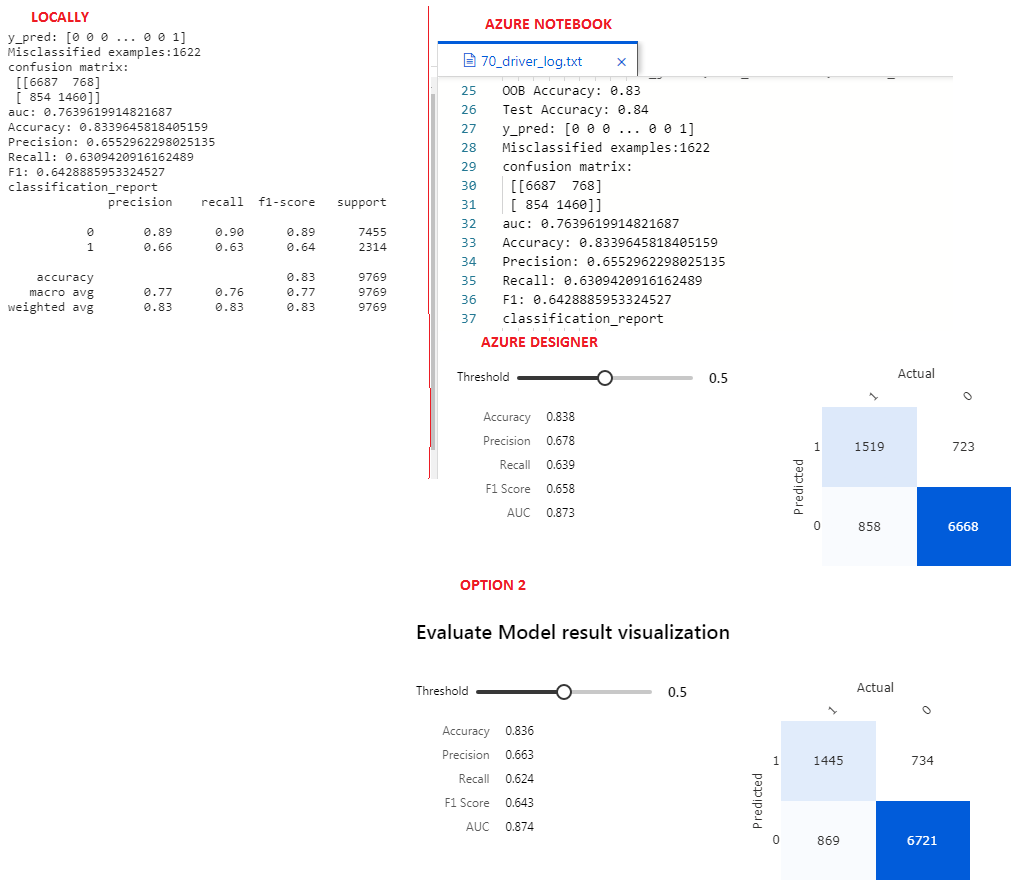

In [28]:
Image(filename='images/Azure/Exp-2/DecisionForest_Bagging/opt2/result.png')

## Designer

https://docs.microsoft.com/en-us/azure/machine-learning/algorithm-module-reference/two-class-decision-forest

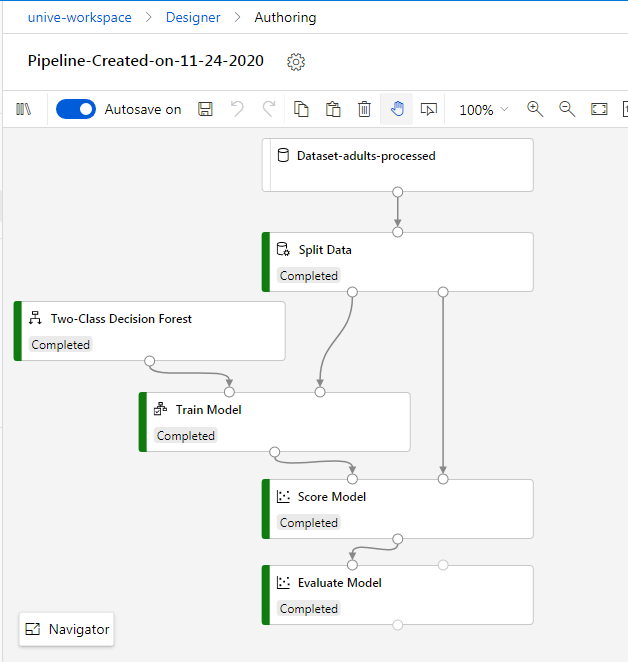

In [98]:
from IPython.display import Image

Image(filename='images/Azure/Exp-2/DecisionForest_Bagging/0-pipeline.png')

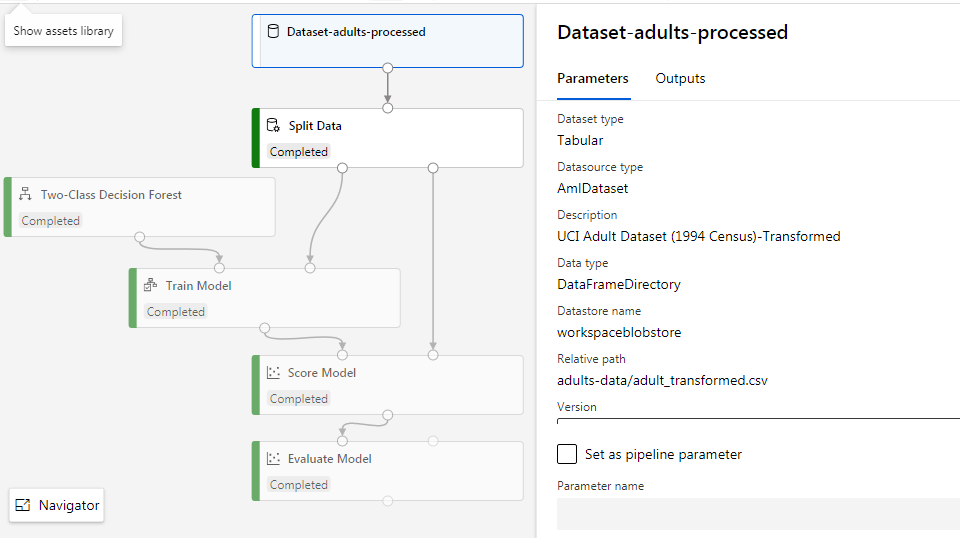

In [99]:
Image(filename='images/Azure/Exp-2/DecisionForest_Bagging/1-dataset.png')

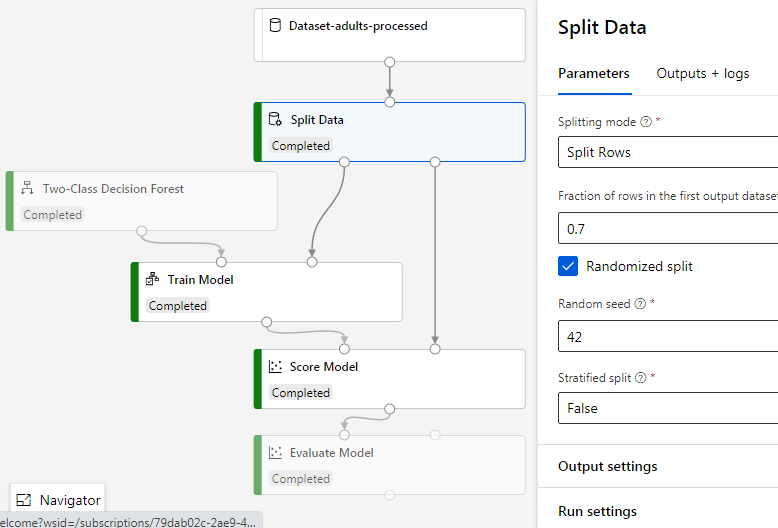

In [100]:
Image(filename='images/Azure/Exp-2/DecisionForest_Bagging/2-split.png')

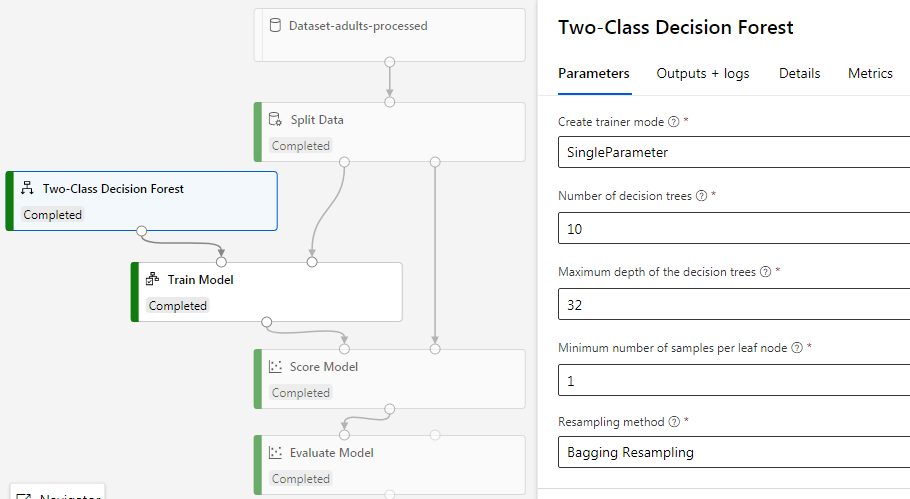

In [101]:
Image(filename='images/Azure/Exp-2/DecisionForest_Bagging/3-classfier.png')

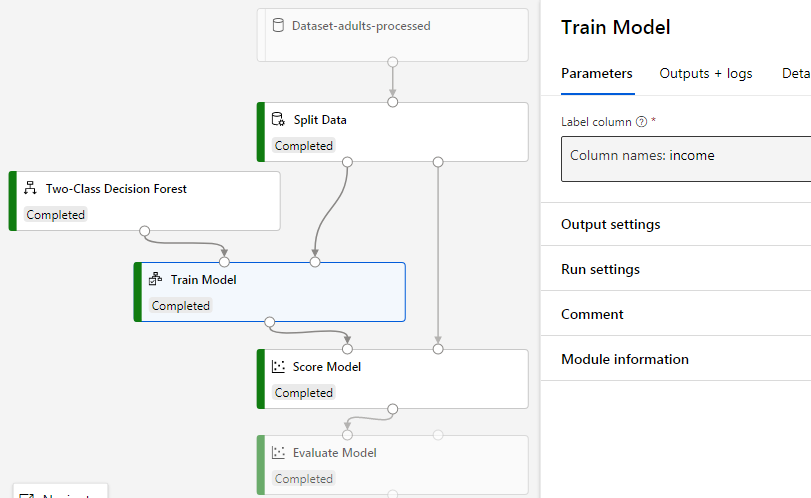

In [102]:
Image(filename='images/Azure/Exp-2/DecisionForest_Bagging/4-train-model.png')

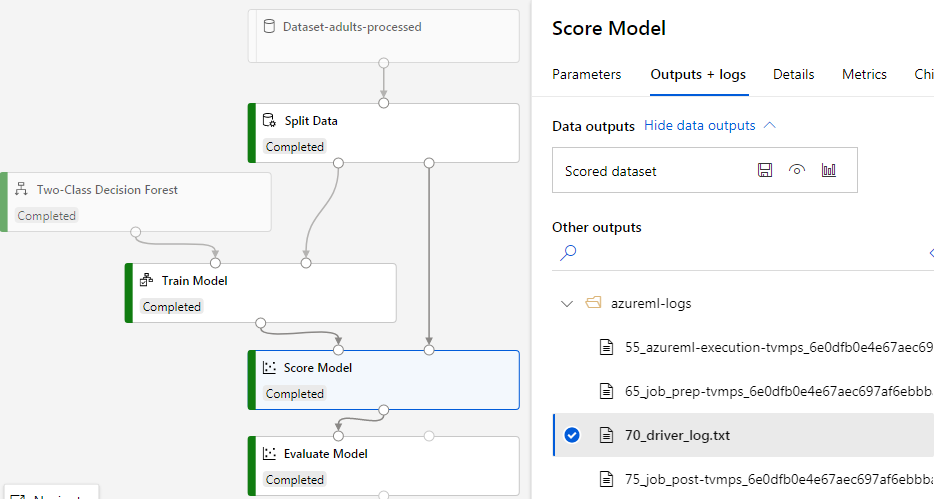

In [103]:
Image(filename='images/Azure/Exp-2/DecisionForest_Bagging/5-score-model.png')

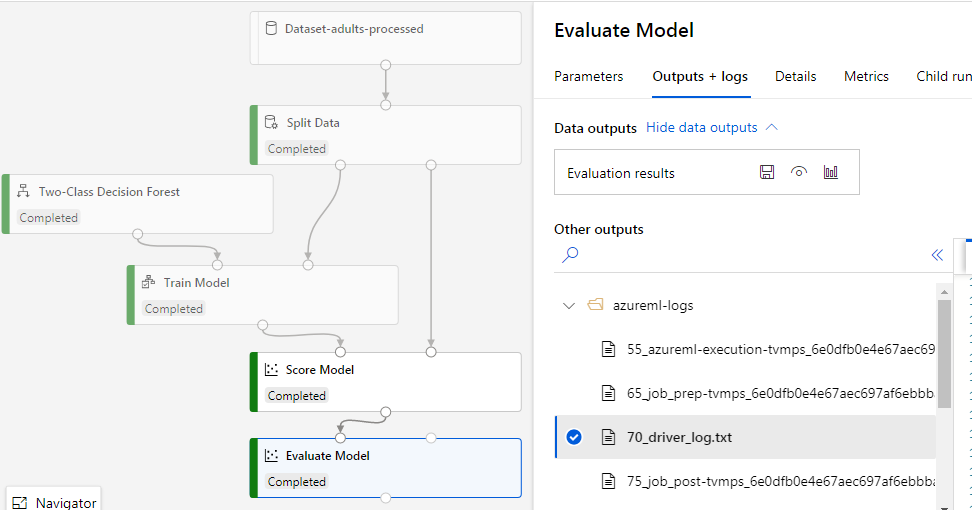

In [104]:
Image(filename='images/Azure/Exp-2/DecisionForest_Bagging/6-evaluate-model.png')

### Option 2

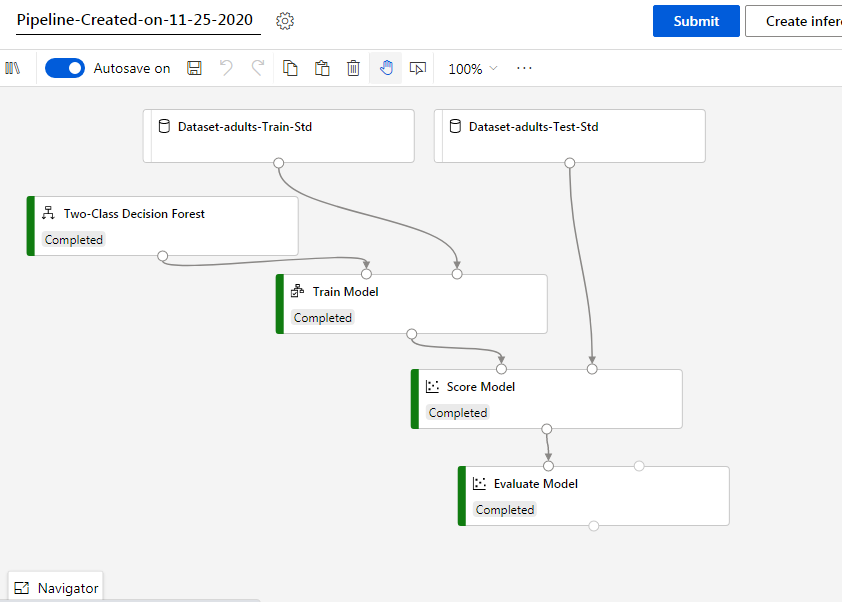

In [20]:
from IPython.display import Image
Image(filename='images/Azure/Exp-2/DecisionForest_Bagging/opt2/0-pipeline.png')

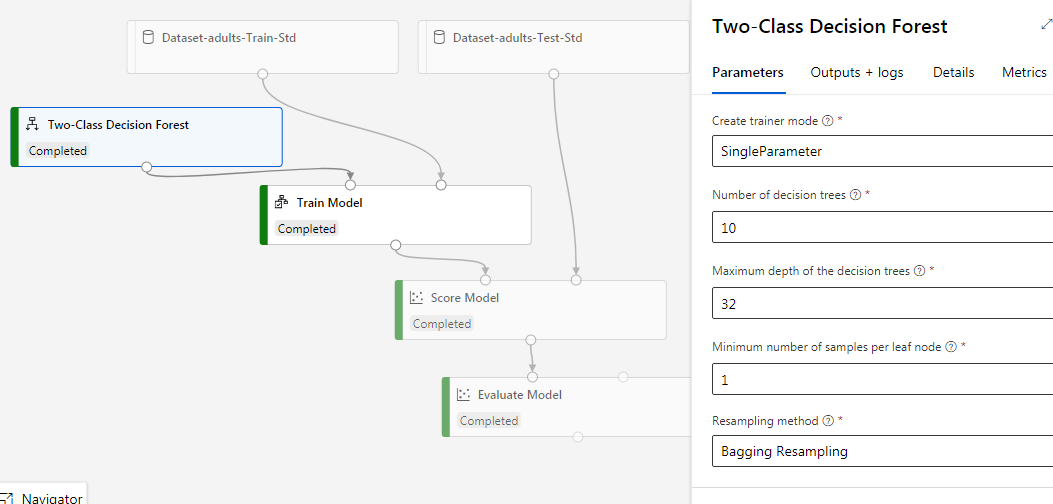

In [21]:
Image(filename='images/Azure/Exp-2/DecisionForest_Bagging/opt2/1-classifier.png')

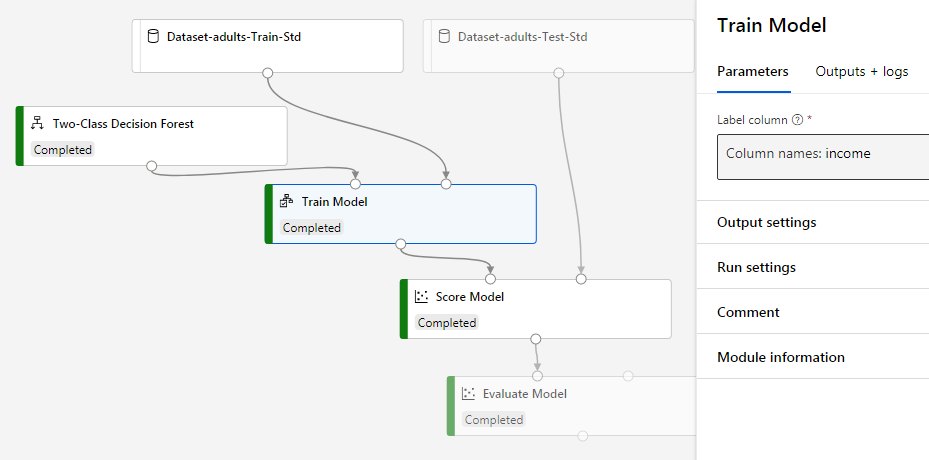

In [22]:
Image(filename='images/Azure/Exp-2/DecisionForest_Bagging/opt2/2-Train.png')

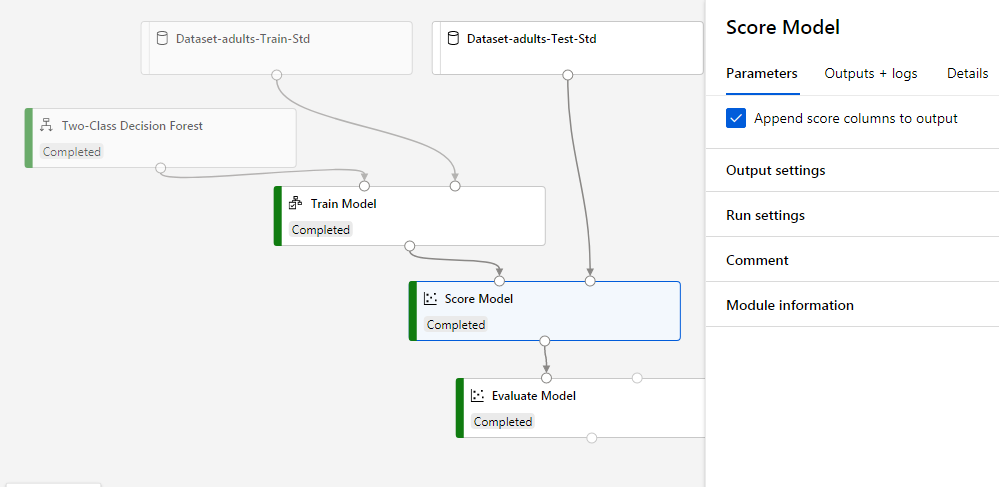

In [23]:
Image(filename='images/Azure/Exp-2/DecisionForest_Bagging/opt2/3-score.png')

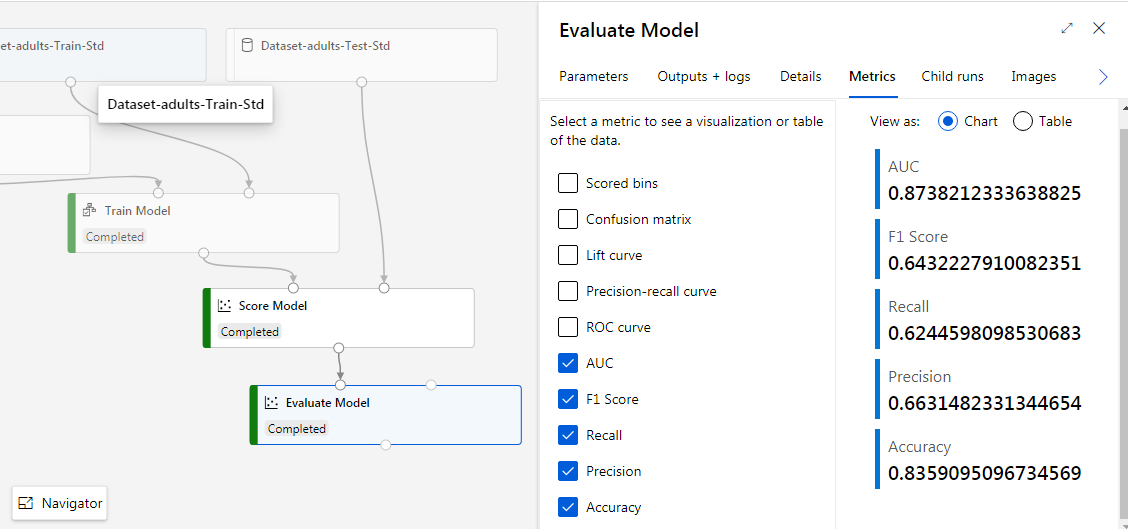

In [24]:
Image(filename='images/Azure/Exp-2/DecisionForest_Bagging/opt2/4-evaluate.png')

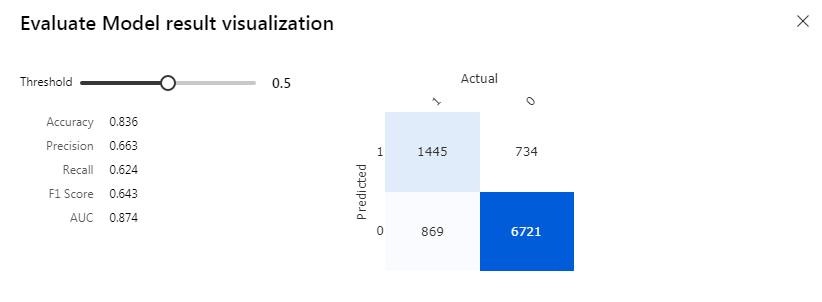

In [25]:
Image(filename='images/Azure/Exp-2/DecisionForest_Bagging/opt2/5-evaluate-1.png')

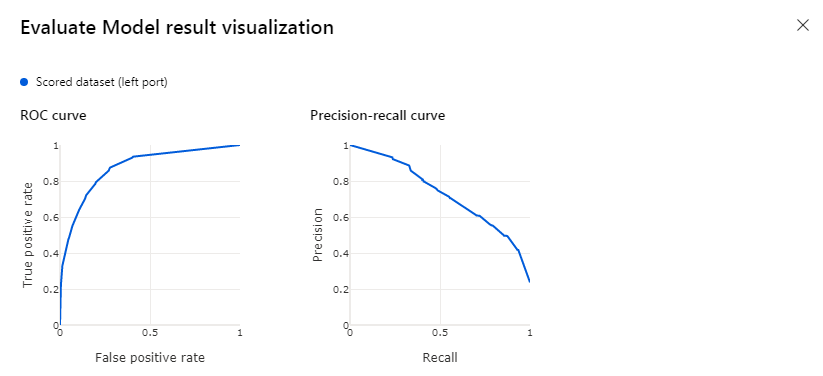

In [26]:
Image(filename='images/Azure/Exp-2/DecisionForest_Bagging/opt2/5-evaluate-2.png')

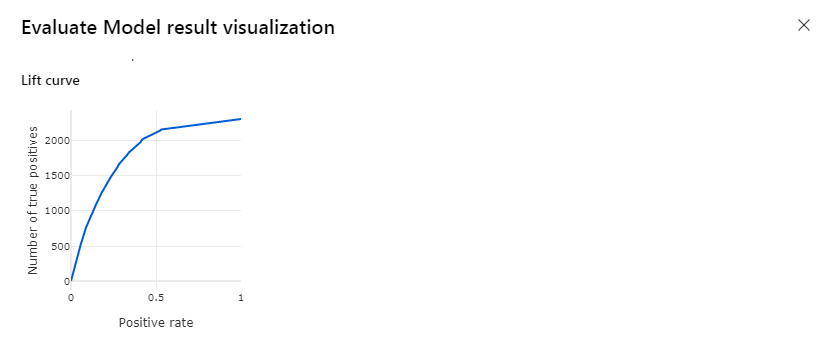

In [27]:
Image(filename='images/Azure/Exp-2/DecisionForest_Bagging/opt2/5-evaluate-3.png')